## Importing Libraries

In [591]:
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt
import scipy
from numpy.polynomial.chebyshev import chebval
from scipy.linalg import fractional_matrix_power

In [592]:
def generate_hermitian_matrix(M, choice=None):
    if choice == "random":
        """Generates an M x M random Hermitian matrix taking values from a normal distribution."""
        H = np.random.randn(M, M) + 1j * np.random.randn(M, M)
        H = 0.5 * (H + H.conj().T)  # Ensure Hermitian
        return H
    elif choice == "synthetic":
        """Generates a synthetic Hermitian matrix."""
        i, j = np.meshgrid(np.arange(M), np.arange(M), indexing="ij")
        H = np.exp(-0.5 * np.abs(i - j)) * np.sin(i + j)
        # H[np.abs(H) < 1e-5] = 0  # Set small values to zero
        return H
    else:
        raise ValueError("Invalid choice. Use 'random' or 'synthetic'.")

## Normalization

In [593]:
def normalize(H, choice, eigenvalsh=None):
    
    if choice == 'none':
        return H
    
    elif choice == 'normal':
        # Normalize the matrix
        norm = np.max(np.abs(eigenvalsh))
        return H / norm
    
    elif choice == 'norm01':
        a = np.min(eigenvalsh) - 1e-6
        b = np.max(eigenvalsh) + 1e-6
        H_normalized = (H - a * np.eye(H.shape[0])) / (b - a)
        return H_normalized
    
    else:
        raise ValueError("Invalid normalization choice. Use 'none', 'normal', or 'norm01'.")

### Diagonalization

In [594]:
def diagonalization(H, Psi_F):
    """
    This function diagonalizes the final state Psi_F.
    """
    # Projection Matrix
    H_proj = Psi_F.conj().T @ H @ Psi_F

    # Overlap Marix
    S = Psi_F.conj().T @ Psi_F

    # Regularization of the overlap matrix
    try:
        eigenvals, eigenvecs = scipy.linalg.eigh(H_proj, S)
    except np.linalg.LinAlgError:
        print("Matrix is not positive definite. Adding small value to diagonal for diagonalization")
        eps = 1e-10
        S += eps * np.eye(S.shape[0])
        eigenvals, eigenvecs = scipy.linalg.eigh(H_proj, S)

    # eigenvals, eigenvecs = scipy.linalg.eigh(H_proj, S)
    
    return eigenvals, eigenvecs

def cholesky_factorization(Psi_F):
    # Overlap Matrix
    S = Psi_F.conj().T @ Psi_F
    try:
        L = np.linalg.cholesky(S)
    except np.linalg.LinAlgError:
        # If the matrix is not positive definite, add a small value to the diagonal
        print("Matrix is not positive definite. Adding small value to diagonal for cholesky factorization.")
        eps = 1e-10
        S += eps * np.eye(S.shape[0])
        L = np.linalg.cholesky(S)

    # L = np.linalg.cholesky(S)
    
    return np.linalg.inv(L).conj().T

# def Cholesky_method(H, Psi_F):
#     eigenvecs = Psi_F @ cholesky_factorization(Psi_F)
#     eigenvals = np.einsum('ji,jk,ki->i', eigenvecs.conj(), H, eigenvecs)
    
#     return eigenvals, eigenvecs


## Orthogonalization

In [595]:
def orthogonalization(Psi_F, eigenvecs):
    Psi_0 = Psi_F @ eigenvecs

    # Normalize the filtered state
    Psi_0 /= np.linalg.norm(Psi_0, axis=0, keepdims=True)
    return Psi_0

## Computing Error

In [596]:
def error(H, Psi_0, N, method, eigenvals, eigenvalsh):
    """
    This function calculates the error.
    """

    if method=='diagonalization':
        idx = np.argsort(eigenvals)
        eigenvals = eigenvals[idx]
        Psi_0 = Psi_0[:, idx]
        return np.max(np.linalg.norm(H @ Psi_0[:,:N] - Psi_0[:,:N] @ np.diag(eigenvals[:N]), axis=0, ord=2))
    
    elif method == 'cholesky':
        eigenvals = np.einsum('ji,jk,ki->i', Psi_0.conj(), H, Psi_0)
        idx = np.argsort(eigenvals)
        eigenvals = eigenvals[idx]
        Psi_0 = Psi_0[:,idx]

        return np.max(np.linalg.norm(H @ Psi_0[:,:N] - Psi_0[:,:N] @ np.diag(eigenvals[:N]), axis=0, ord=2))


    elif method == 'none':
        idx = np.argsort(eigenvals)
        eigenvals = eigenvals[idx]
        return np.linalg.norm(eigenvals[:N] - eigenvalsh[:N], ord=np.inf)
        
    else:
        raise ValueError("Invalid method. Use 'diagonalization' or 'cholesky' or 'none'.")

## Quantum Krylov Methods (QSMs)
### QITE

In [597]:
def QITE(H, psi_0, N, buffer, deltatau, epsilon, max_iter, eigenvalsh, orthogonalize=False):

    Ntilde = int(np.ceil((1+(buffer/100)) * N))

    H_norm = normalize(H, choice='norm01', eigenvalsh = eigenvalsh)

    itr = 0
    abs_error = [1e16]
    eigenvals = np.empty((Ntilde), dtype=complex)

    print()
    print("QITE Krylov basis No-Filter Diagonalization Parameters")
    print(f"Dimension of H matrix: {H.shape[0]}")
    print(f"Initial Space Size: {Ntilde}")
    print(f"Number of desired Eigenvalues: {N}")
    print(f"Buffer: {buffer}%")
    print(f"Tau: {deltatau}")
    print(f"Convergence Threshold: {epsilon}")
    print(f"Max Iterations: {max_iter}")
    print(f"Orthogonalize Matrix: {orthogonalize}")
    print()

    last_valid_eigenvals = None
    exp_H = expm(- deltatau * H_norm)
    eigh = np.linalg.eigvalsh(H_norm)
    

    while itr < max_iter and abs_error[-1] >= epsilon and Ntilde <= H.shape[0]:
        
        # Initialization
        if itr == 0:
            Psi_0 = np.empty((H.shape[0], Ntilde), dtype=complex)
            v = psi_0.copy()
            v /= np.linalg.norm(v)
            for i in range(Ntilde):
                Psi_0[:, i] = v.flatten()
                v = exp_H @ v
                v /= np.linalg.norm(v)
        else:
            # Reuse previous Psi_F and append just one column
            Psi_0 = np.column_stack((Psi_0, exp_H @ Psi_0[:, -1]))
            Psi_0[:, -1] /= np.linalg.norm(Psi_0[:, -1])


        # No filtering
        Psi_F = Psi_0
        
        # Orthogonalization
        if orthogonalize:
            try:
                L = cholesky_factorization(Psi_F)
                Psi_F = orthogonalization(Psi_F, L)
            except np.linalg.LinAlgError as e:
                print(f"Orthogonalizing Error at iteration {itr}: {str(e)}")
                print("Returning last successfully computed eigenvalues/eigenvectors.")
                return last_valid_eigenvals, abs_error, itr

        # Diagonalization
        try:
            eigenvals, _ = diagonalization(H_norm, Psi_F)
        except np.linalg.LinAlgError as e:
            print(f"Diagonalization Error at iteration {itr}: {str(e)}")
            print("Returning last successfully computed eigenvalues/eigenvectors.")
            return last_valid_eigenvals, abs_error, itr
        
        # Compute Errors
        idx = np.argsort(eigenvals)
        eigenvals = eigenvals[idx]
        abs_error.append(np.linalg.norm(eigenvals[:N] - eigh[:N], ord=np.inf))

        last_valid_eigenvals = eigenvals

        Ntilde +=1
        itr+=1

    return eigenvals, abs_error, itr

### QRTE

In [598]:
def QRTE(H, psi_0, N, buffer, deltatau, epsilon, max_iter, eigenvalsh, orthogonalize=False):

    Ntilde = int(np.ceil((1+(buffer/100)) * N))

    H_norm = normalize(H, choice='normal', eigenvalsh = eigenvalsh)
    itr = 0
    abs_error = [1e16]
    eigenvals = np.empty((Ntilde), dtype=complex)

    print()
    print("QRTE Krylov basis No-Filter Diagonalization Parameters")
    print(f"Dimension of H matrix: {H.shape[0]}")
    print(f"Number of desired Eigenvalues: {N}")
    print(f"Initial Space Size: {Ntilde}")
    print(f"Buffer: {buffer}%")
    print(f"Tau: {deltatau}")
    print(f"Convergence Threshold: {epsilon}")
    print(f"Max Iterations: {max_iter}")
    print(f"Orthogonalize Matrix: {orthogonalize}")
    print()

    last_valid_eigenvals = None
    deltaE_L = np.abs(eigenvalsh[Ntilde-1] - eigenvalsh[0])
    deltat = np.pi/deltaE_L
    exp_H = expm(-1j * deltat * H_norm)
    eigh = np.linalg.eigvalsh(H_norm)

    while itr < max_iter and abs_error[itr]>=epsilon and Ntilde <= H.shape[0]:
        
        # Initialization
        if itr==0:
            Psi_0 = np.empty((H.shape[0], Ntilde), dtype=complex)
            for i in range(Ntilde):
            # Shift the range to be from 0 to N-1
                i_n = i - Ntilde//2
                Psi_0[:, i] = (np.linalg.matrix_power(exp_H, i_n) @ psi_0).flatten()
        
            Psi_0 /= np.linalg.norm(Psi_0, axis=0, keepdims=True) # Not neessary since we are using a unitary operator anyways
        
        else:
            # Reuse previous Psi_F and append just one column
            if (Ntilde % 2) == 0:
                Psi_0 = np.column_stack((np.linalg.matrix_power(exp_H, -Ntilde//2) @ psi_0, Psi_0))
                Psi_0[:, 0] /= np.linalg.norm(Psi_0[:, 0])
            else:
                Psi_0 = np.column_stack((Psi_0,np.linalg.matrix_power(exp_H, (Ntilde//2)) @ psi_0))
                Psi_0[:, -1] /= np.linalg.norm(Psi_0[:, -1])

        # No filtering
        Psi_F = Psi_0
        
        # Orthogonalization
        if orthogonalize:
            try:
                L = cholesky_factorization(Psi_F)
                Psi_F = orthogonalization(Psi_F, L)
            except np.linalg.LinAlgError as e:
                print(f"Orthogonalizing Error at iteration {itr}: {str(e)}")
                print("Returning last successfully computed eigenvalues/eigenvectors.")
                return last_valid_eigenvals, abs_error, itr

        # Diagonalization
        try:
            eigenvals, _ = diagonalization(H_norm, Psi_F)
        except np.linalg.LinAlgError as e:
            print(f"Diagonalization Error at iteration {itr}: {str(e)}")
            print("Returning last successfully computed eigenvalues/eigenvectors.")
            return last_valid_eigenvals, abs_error, itr
        
        # Compute Errors
        idx = np.argsort(eigenvals)
        eigenvals = eigenvals[idx]
        abs_error.append(np.linalg.norm(eigenvals[:N] - eigh[:N], ord=np.inf))

        last_valid_eigenvals = eigenvals

        Ntilde +=1
        itr+=1

    return eigenvals, abs_error, itr

### Chebyshev Quantum Krylov

In [599]:
def chebyshev(H, psi_0, N, buffer, deltatau, epsilon, max_iter, eigenvalsh, orthogonalize=False):

    Ntilde = int(np.ceil((1+(buffer/100)) * N))

    H_norm = normalize(H, choice='normal', eigenvalsh=eigenvalsh)
    itr = 0
    abs_error = [1e16]
    eigenvals = np.empty((N), dtype=complex)

    print()
    print("Chebyshev Quantum Krylov basis No-Filter Diagonalization Parameters")
    print(f"Dimension of H matrix: {H.shape[0]}")
    print(f"Number of desired Eigenvalues: {N}")
    print(f"Initial Space Size: {Ntilde}")
    print(f"Buffer: {buffer}%")
    print(f"Tau: {deltatau}")
    print(f"Convergence Threshold: {epsilon}")
    print(f"Max Iterations: {max_iter}")
    print(f"Orthogonalize Matrix: {orthogonalize}")
    print()

    last_valid_eigenvals = None
    eigh = np.linalg.eigvalsh(H_norm)

    while itr < max_iter and abs_error[itr]>=epsilon and Ntilde <= H.shape[0]:
        
        # Initialization
        if itr == 0:
            Psi_0 = np.empty((H.shape[0], Ntilde), dtype=complex)
            T_prev = np.eye(H.shape[0], dtype=complex)
            T_curr = H_norm.copy()
            Psi_0[:, 0] = psi_0.flatten()
            Psi_0[:, 1] = (T_curr @ psi_0).flatten()
            for i in range(2, Ntilde):
                T_next = 2 * H_norm @ T_curr - T_prev
                T_prev, T_curr = T_curr, T_next
                Psi_0[:, i] = (T_curr @ psi_0).flatten()

                Psi_0 /= np.linalg.norm(Psi_0, axis=0, keepdims=True)
        else:
            T_next = 2 * H_norm @ T_curr - T_prev
            T_prev, T_curr = T_curr, T_next
            Psi_0 = np.column_stack((Psi_0, (T_curr @ psi_0).flatten()))
            Psi_0[:, -1] /= np.linalg.norm(Psi_0[:, -1])


        # No filtering
        Psi_F = Psi_0
        
        # Orthogonalization
        if orthogonalize:
            try:
                L = cholesky_factorization(Psi_F)
                Psi_F = orthogonalization(Psi_F, L)
            except np.linalg.LinAlgError as e:
                print(f"Orthogonalizing Error at iteration {itr}: {str(e)}")
                print("Returning last successfully computed eigenvalues/eigenvectors.")
                return last_valid_eigenvals, abs_error, itr

        # Diagonalization
        try:
            eigenvals, _ = diagonalization(H_norm, Psi_F)
        except np.linalg.LinAlgError as e:
            print(f"Diagonalization Error at iteration {itr}: {str(e)}")
            print("Returning last successfully computed eigenvalues/eigenvectors.")
            return last_valid_eigenvals, abs_error, itr
        
        # Compute Errors
        idx = np.argsort(eigenvals)
        eigenvals = eigenvals[idx]
        abs_error.append(np.linalg.norm(eigenvals[:N] - eigh[:N], ord=np.inf))

        last_valid_eigenvals = eigenvals

        Ntilde +=1
        itr+=1

    return eigenvals, abs_error, itr

## Our method

In [600]:
def method1(H, psi_0, N, buffer, filtertau, epsilon, max_iter, eigenvalsh):

    Ntilde = int(np.ceil((1+(buffer/100)) * N))

    itr = 0
    abs_error = [1e16]
    eigenvals = np.empty((N), dtype=complex)

    print()
    print("My Method with Chebyshev basis with QITE Filter Diagonalization Parameters")
    print(f"Dimension of H matrix: {H.shape[0]}")
    print(f"Number of desired Eigenvalues: {N}")
    print(f"Initial Space Size: {Ntilde}")
    print(f"Buffer: {buffer}%")
    print(f"Tau: {filtertau}")
    print(f"Convergence Threshold: {epsilon}")
    print(f"Max Iterations: {max_iter}")
    print()

    last_valid_eigenvals = None
    last_valid_eigenvecs = None

    # Initialization
    H_norm = normalize(H, choice='norm01', eigenvalsh=eigenvalsh)

    Psi_0 = np.empty((H.shape[0], Ntilde), dtype=complex)
    T_prev = np.eye(H.shape[0], dtype=complex)
    T_curr = H_norm.copy()
    Psi_0[:, 0] = psi_0.flatten()
    Psi_0[:, 1] = (T_curr @ psi_0).flatten()
    for i in range(2, Ntilde):
        T_next = 2 * H_norm @ T_curr - T_prev
        T_prev, T_curr = T_curr, T_next
        Psi_0[:, i] = (T_curr @ psi_0).flatten()

    Psi_0 /= np.linalg.norm(Psi_0, axis=0, keepdims=True)

    exp_H = expm(-1 * filtertau * H_norm)
    eigh = np.linalg.eigvalsh(H_norm)

    
    while itr < max_iter and abs_error[itr]>=epsilon:

        # Filtering
        Psi_F = exp_H @ Psi_0
        # Normalize the filtered state
        Psi_F /= np.linalg.norm(Psi_F, axis=0, keepdims=True)
        
        # Diagonalization
        try:
            eigenvals, eigenvecs = diagonalization(H_norm, Psi_F)
            Psi_0 = orthogonalization(Psi_F, eigenvecs)
            
        except np.linalg.LinAlgError as e:
            print(f"Diagonalization Error at iteration {itr}: {str(e)}")
            print("Returning last successfully computed eigenvalues/eigenvectors.")
            return last_valid_eigenvals, last_valid_eigenvecs, abs_error, itr
                
        # Compute Errors
        idx = np.argsort(eigenvals)
        eigenvals = eigenvals[idx]
        Psi_0 = Psi_0[:, idx]
        abs_error.append(np.linalg.norm(eigenvals[:N] - eigh[:N], ord=np.inf))

        last_valid_eigenvals = eigenvals
        last_valid_eigenvecs = Psi_0
        itr+=1

    return eigenvals, eigenvecs, abs_error, itr

## Analysis

In [601]:
# Parameters
np.random.seed(15) # For reproducibility
M =  1024 # Dimension of the matrix
N = 1  # Number of eigenvalues
buffer = 50  # Buffer for the number of eigenvalues
Ntilde = int(np.ceil((1+(buffer/100)) * N))  # Number of eigenvalues to be found
deltatau = 1 # Time step for the QITE method
filtertau = 20

epsilon = 1e-12  # Tolerance for convergence
max_iter = 100 # Maximum number of iterations

H = generate_hermitian_matrix(M, choice='synthetic')

psi_0 = np.random.randn(M, 1) + 1j*np.random.randn(M, 1)
psi_0 /= np.linalg.norm(psi_0, axis=0, keepdims=True)

print("Matrix Size: ", M)
print("Initial space size: ", Ntilde)
print("Number of Eigenvalues desired: ", N)
print("Buffer: ", buffer)
print("Time Step: ", deltatau)
print("Filter Time Step: ", filtertau)
print("Convergence Threshold: ", epsilon)
print("Max Iterations: ", max_iter)

Matrix Size:  1024
Initial space size:  2
Number of Eigenvalues desired:  1
Buffer:  50
Time Step:  1
Filter Time Step:  20
Convergence Threshold:  1e-12
Max Iterations:  100


## Implementation

In [602]:
eigenvalsh = np.linalg.eigvalsh(H)
qite_eigenvals, qite_abs_error, qite_itr = QITE(H, psi_0, N, buffer, deltatau, epsilon, max_iter, eigenvalsh, orthogonalize=False)
# qite_ortho_eigenvals, qite_ortho_abs_error, qite_ortho_itr = QITE(H, psi_0, Ntilde, buffer, deltatau, epsilon, max_iter, orthogonalize=True)
qrte_eigenvals, qrte_abs_error, qrte_itr = QRTE(H, psi_0, N, buffer, deltatau, epsilon, max_iter, eigenvalsh, orthogonalize=False)
# qrte_ortho_eigenvals, qrte_ortho_abs_error, qrte_ortho_itr = QRTE(H, psi_0, Ntilde, buffer, deltatau, epsilon, max_iter, orthogonalize=True)
chebyshev_eigenvals, chebyshev_abs_error, chebyshev_itr = chebyshev(H, psi_0, N, buffer, deltatau, epsilon, max_iter, eigenvalsh, orthogonalize=False)
# chebyshev_ortho_eigenvals, chebyshev_ortho_abs_error, chebyshev_ortho_itr = chebyshev(H, psi_0, Ntilde, buffer, deltatau, epsilon, max_iter, orthogonalize=True)
method1_eigenvals, method1_eigenvecs, method1_abs_error, method1_itr = method1(H, psi_0, N, buffer, filtertau, epsilon, max_iter, eigenvalsh)
# method2_eigenvals, method2_eigenvecs, method2_abs_error, method2_itr = method1(H, psi_0, N, buffer, filtertau, epsilon, max_iter, filter_choice='QITE_2', orthogonalize=True)


QITE Krylov basis No-Filter Diagonalization Parameters
Dimension of H matrix: 1024
Initial Space Size: 2
Number of desired Eigenvalues: 1
Buffer: 50%
Tau: 1
Convergence Threshold: 1e-12
Max Iterations: 100
Orthogonalize Matrix: False

Matrix is not positive definite. Adding small value to diagonal for diagonalization
Matrix is not positive definite. Adding small value to diagonal for diagonalization
Matrix is not positive definite. Adding small value to diagonal for diagonalization
Matrix is not positive definite. Adding small value to diagonal for diagonalization
Matrix is not positive definite. Adding small value to diagonal for diagonalization
Matrix is not positive definite. Adding small value to diagonal for diagonalization
Matrix is not positive definite. Adding small value to diagonal for diagonalization
Matrix is not positive definite. Adding small value to diagonal for diagonalization
Matrix is not positive definite. Adding small value to diagonal for diagonalization
Matrix i

In [603]:
a = np.min(eigenvalsh) - 1e-6
b = np.max(eigenvalsh) + 1e-6
print("Printing Eigenvalues")
print("Original for QITE", np.sort(np.linalg.eigvalsh((H - a * np.eye(M)) / (b - a)))[:N])
print("QITE:", qite_eigenvals[:N]) 
# print("QITE with Orthogonalization:", qite_ortho_eigenvals[:N])
print("Method 1:", method1_eigenvals[:N])
# print("Method 2:", method2_eigenvals[:N])
print()
print("Original for QRTE:",np.sort(np.linalg.eigvalsh(H/np.linalg.norm(H,ord=2)))[:N])
print("QRTE:", qrte_eigenvals[:N])
# print("QRTE with Orthogonalization:", qrte_ortho_eigenvals[:N])
print("Chebyshev:", chebyshev_eigenvals[:N])
# print("Chebyshev with Orthogonalization:", chebyshev_ortho_eigenvals[:N])

Printing Eigenvalues
Original for QITE [2.43256058e-07]
QITE: [-8.63035596e-07]
Method 1: [7.15912108e-05]

Original for QRTE: [-0.99999994]
QRTE: [-0.56396642]
Chebyshev: [-0.99987967]


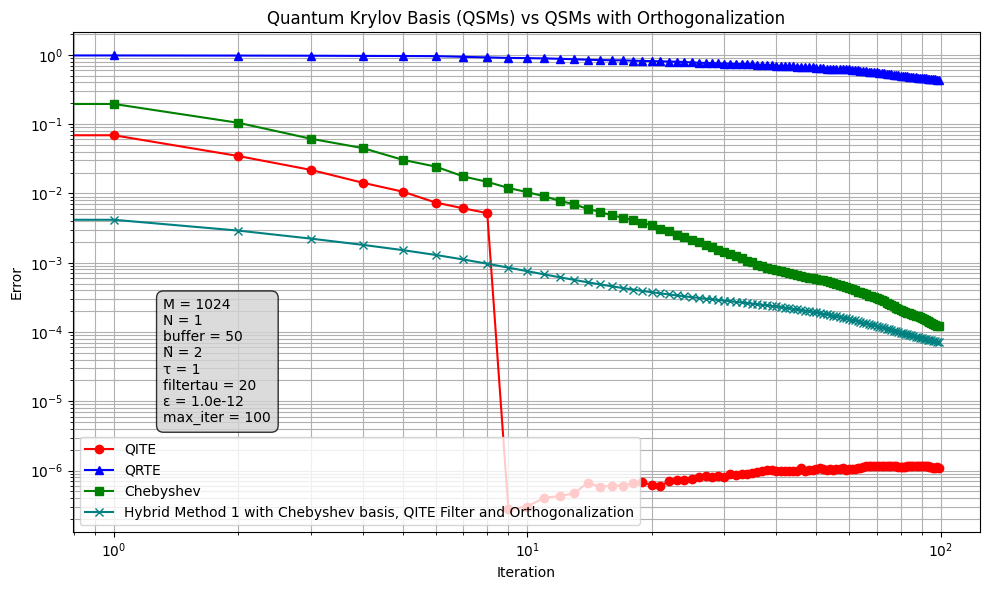

In [604]:
plt.figure(figsize=(10, 6))
plt.title('Quantum Krylov Basis (QSMs) vs QSMs with Orthogonalization')
plt.plot(np.arange(qite_itr), qite_abs_error[1:], marker='o', label='QITE', color='red')
# plt.plot(np.arange(qite_ortho_itr), qite_ortho_abs_error[1:], marker='^', label='QITE_w/ ortho', color='orange')
plt.plot(np.arange(qrte_itr), qrte_abs_error[1:], marker='^', label='QRTE', color='blue')
# plt.plot(np.arange(qrte_ortho_itr), qrte_ortho_abs_error[1:], marker='s', label='QRTE_w/ ortho', color='magenta')
plt.plot(np.arange(chebyshev_itr), chebyshev_abs_error[1:], marker='s', label='Chebyshev', color='green')
# plt.plot(np.arange(chebyshev_ortho_itr), chebyshev_ortho_abs_error[1:], marker='d', label='Chebyshev_w/ ortho', color='cyan')
plt.plot(np.arange(method1_itr), method1_abs_error[1:], marker='x', label='Hybrid Method 1 with Chebyshev basis, QITE Filter and Orthogonalization', color='teal')
# plt.plot(np.arange(method2_itr), method2_abs_error[1:], marker='x', label='Method 2 with Chebyshev basis, QITE_2 Filter and Orthogonalization', color='purple')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.grid(True, 'both', 'both')
plt.legend()
info_text = (
    f"M = {M}\n"
    f"N = {N}\n"
    f"buffer = {buffer}\n"
    f"Ñ = {Ntilde}\n"
    f"τ = {deltatau}\n"
    f"filtertau = {filtertau}\n"
    f"ε = {epsilon:.1e}\n"
    f"max_iter = {max_iter}"
)

# Adjust position (x=0.65, y=0.5) as needed
plt.text(0.1, 0.22, info_text, transform=plt.gca().transAxes,
         fontsize=10, bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgrey', alpha=0.8))
plt.legend()
plt.tight_layout()
plt.show()